# **Project:** Anomaly Detection in Credit Card


### **Objective:** 
- The objective of this project to build model and make it capable enough to detect the whether currently occured transaction is AUTHENTICATE or FRADULUENT.

### Import all the dependencies


In [1]:
# File System Management
import time, psutil, os, gc

# Mathematical functions
import math

# Data Manipulation
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train Test split
from sklearn.model_selection import train_test_split

# Progress bar for loop
from tqdm.contrib import itertools

In [2]:
# Record the starting time
start_time = time.time()

# Tracking the os and memory usage
process = psutil.Process(os.getpid())

### Load the dataset

In [3]:
data_filePath = '/kaggle/input/creditcardfraud/creditcard.csv'

# load the csv file
data = pd.read_csv(data_filePath)
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
data.head()


Memory usage         67.36 MB
Dataset shape    (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Train-Validation-Test Splits

In [4]:
# split the dataset by target class
data_auth, data_fraud = data[data['Class'] == 0], data[data['Class'] == 1]

# Features-target split from authenticate data
Features_auth, target_auth = data_auth.drop('Class', axis=1), data_auth['Class'] 
Features_fraud, target_fraud = data_fraud.drop('Class', axis=1), data_fraud['Class'] 

# splitting the authenticate data and constructing the training set
X_train, X_test, y_train, y_test = train_test_split(Features_auth, target_auth, test_size=0.2, random_state = 40)
## splitting the testing data into validation and testing data
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 40)
## Constructed the separate dataset for testing and validation
data_test_auth, data_validate_auth = pd.concat([X_test, y_test], axis=1), pd.concat([X_val, y_val], axis=1)

# Splitting Fraudulent data 
X_val, X_test, y_val, y_test = train_test_split(Features_fraud, target_fraud, test_size=0.5, random_state=40)
data_test_fraud, data_validate_fraud = pd.concat([X_test, y_test], axis=1), pd.concat([X_val, y_val], axis=1)

# Merge both authenticate and fraudulent validate and testing data into one VALIDATE AND TESTING DATASET
TESTING_DATASET, VALIDATE_DATASET = pd.concat([data_test_auth, data_test_fraud], axis=0), pd.concat([data_validate_auth, data_validate_fraud], axis=0)

# Feature-Label splitting on validation and testing dataset
X_val, y_val = VALIDATE_DATASET.drop('Class', axis=1), VALIDATE_DATASET['Class']
X_test, y_test = TESTING_DATASET.drop('Class', axis=1), TESTING_DATASET['Class']

## Feature Engineering

### Freedman-Diaconis rule 
Majorly used for selecting the number of bins based on the total number of observations.
**k ~ n^1/3** 
where,
* k: Number of bins
* n: Number of observations

In [5]:
# Setting number of bins
bins_train = math.floor(len(X_train)**(1/3))

In [6]:
# Feature: Time
for df in [X_train, X_val, X_test]:
    # Calculate Day and remaining time
    df['Day'] = df['Time'] // (24 * 60 * 60)
    remain_time = df['Time'] % (24 * 60 * 60)
    
    # Calculate Hour and remaining time
    df['Hour'] = remain_time // (60 * 60)
    remain_time = remain_time % (60 * 60)
    
    # Calculate Minute and Second
    df['Minute'] = remain_time // 60
    df['Second'] = remain_time % 60

X_train[['Time', 'Day', 'Hour', 'Minute', 'Second']].head()


,Time,Day,Hour,Minute,Second
19594,30401.0,0.0,8.0,26.0,41.0
124712,77397.0,0.0,21.0,29.0,57.0
167920,118964.0,1.0,9.0,2.0,44.0
47377,43191.0,0.0,11.0,59.0,51.0
41731,40804.0,0.0,11.0,20.0,4.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


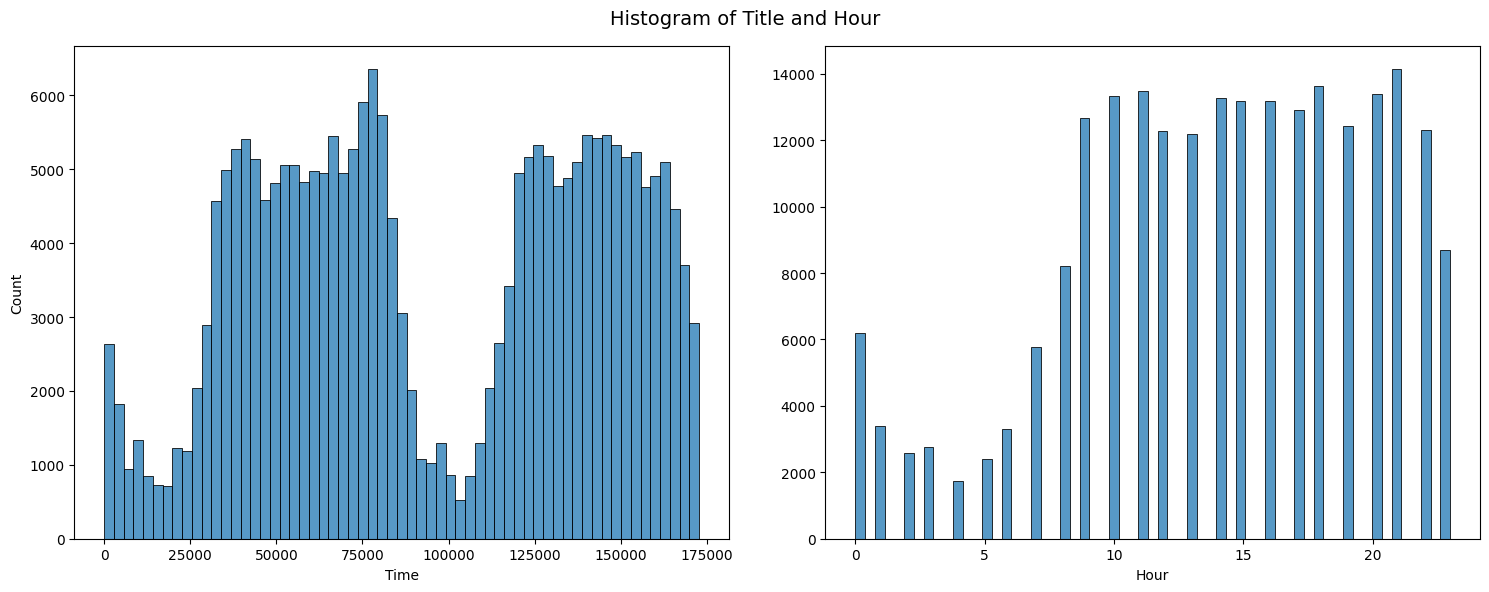

In [7]:
# visualization
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(data = X_train, x = 'Time', bins=bins_train, ax=ax[0])
sns.histplot(data = X_train, x = 'Hour', bins=bins_train, ax=ax[1])
ax[1].set_ylabel(' ')
plt.suptitle("Histogram of Title and Hour", size=14)
plt.tight_layout()
plt.show()

In [8]:
# Feature: Amount

# As the distribution of amount has extreme positive skewness, so we transformed amount(x) -> log(x + 0.001) named as amount_transformed
for df in [X_train, X_test, X_val]:
    df['Amount_transformed'] = np.log10(df['Amount'] + 0.001)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


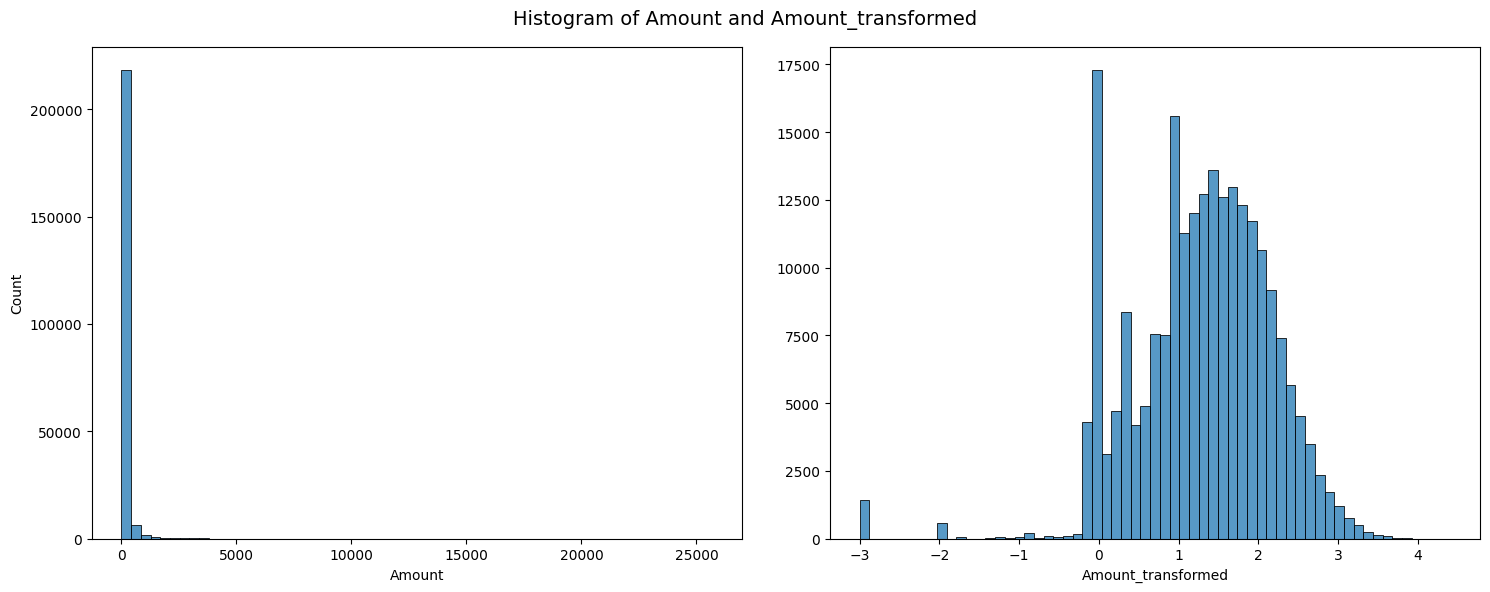

In [9]:
# Visualized
fig, ax = plt.subplots(1, 2, figsize = (15,6), sharey=False)
sns.histplot(data=X_train, x='Amount', bins=bins_train, ax=ax[0])
sns.histplot(data=X_train, x='Amount_transformed', bins=bins_train, ax=ax[1])
ax[1].set_ylabel(' ')
plt.suptitle("Histogram of Amount and Amount_transformed", size=14)
plt.tight_layout()
plt.show()

In [10]:
# Discarding the unncessary columns
for df in [X_train, X_val, X_test]:
    df.drop(['Time', 'Day', 'Minute','Second', 'Amount'], axis=1, inplace=True)

## Feature Selection

The problem at hand have around 30 features, which is a lot, having more features is crucial for precisly detecting fraudulent transaction only if they are contributing in classifying the transaction, dataset with many features that not likely contribute much in classifying a transaction as authentic or fraudulent then it should be exclude from the dataset, And the process involved in this called "**FEATURE SELECTION**"

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

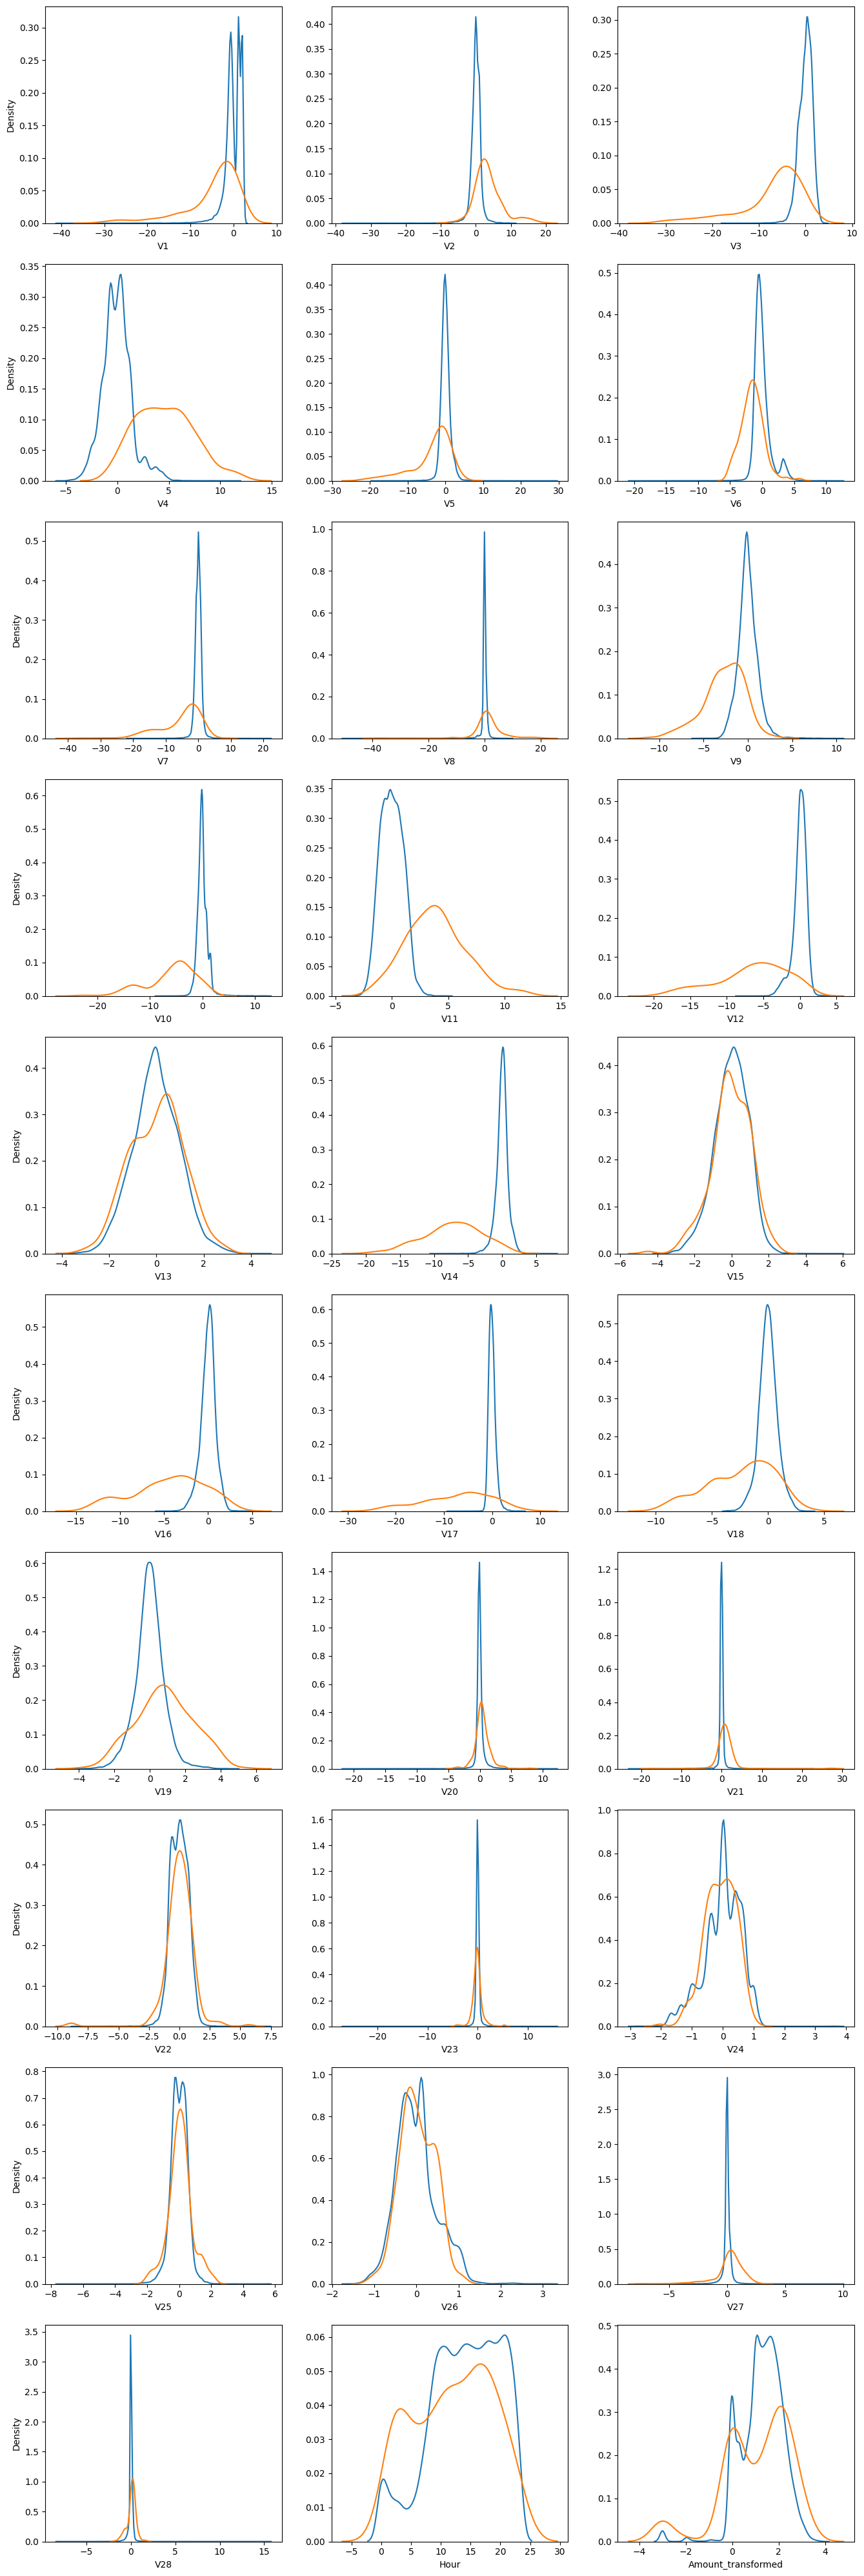

In [11]:
# Comparing the feature distribution for authentic and fraudulent transactions

VALIDATE_DATA = pd.concat([X_val, y_val], axis=1)
VALIDATE_DATA_AUTH, VALIDATE_DATA_FRAUD = VALIDATE_DATA[VALIDATE_DATA['Class'] == 0], VALIDATE_DATA[VALIDATE_DATA['Class'] == 1] 
cols, ncols = list(X_val.columns), 3
nrows = math.ceil(len(cols) / ncols)

fig, ax = plt.subplots(nrows, ncols, figsize=(4.5 * ncols, 4 * nrows))
for i in range(len(cols)):
    sns.kdeplot(VALIDATE_DATA_AUTH[cols[i]], ax=ax[i //ncols, i % ncols])
    sns.kdeplot(VALIDATE_DATA_FRAUD[cols[i]], ax=ax[i //ncols, i % ncols])
    
    if i % ncols !=0:
        ax[i // ncols, i % ncols].set_ylabel(' ')
plt.tight_layout()
plt.show()

In [21]:
# Feature Selection
cols = ['V4', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18', 'V19', 'Hour']
Fs_X_train,Fs_X_val, Fs_X_test = X_train[cols], X_val[cols], X_test[cols]
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Hour,Amount_transformed
19594,1.121347,-0.699179,0.076185,-0.706232,-0.703027,-0.587016,-0.150871,-0.109071,-1.421118,0.696828,...,-0.041639,-0.487576,0.071691,0.208420,0.189962,-0.542667,-0.021184,0.022294,8.0,2.079185
124712,-1.447937,1.588026,1.510572,1.474933,-0.542238,1.561748,-2.005665,-5.053159,0.025915,-0.994011,...,-2.606748,1.190330,0.206244,0.053912,-0.245679,-0.210981,0.225635,0.042488,21.0,1.041432
167920,-2.845270,2.187520,2.506390,4.840766,-1.459572,2.847040,-3.415069,-4.340194,-0.194490,0.940258,...,-2.596990,1.565396,0.384032,0.034866,0.170369,0.622280,0.164789,-0.014722,9.0,-3.000000
47377,-0.951725,1.004371,0.644821,0.565273,-0.053900,1.912203,1.513640,0.016396,-0.752337,0.085418,...,0.028785,0.284846,-0.486074,-1.697856,0.557154,-0.001074,-0.104567,-0.074238,11.0,2.378400
41731,0.747690,-1.621906,-0.131882,-0.428860,-1.249486,-0.697124,-0.077855,-0.313109,-0.790539,0.473755,...,0.545421,0.741497,-0.536791,0.117714,0.590053,-0.013907,-0.060230,0.071999,11.0,2.567086


In [22]:
# Normal pdf
def normal_density(x, mu, sigma):
    assert sigma > 0, "Standard deviation must be positive"
    f = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(- (1 / 2) * ((x - mu) / sigma)**2)
    return f

In [23]:
# Product of normal pdfs
def normal_product(x_vec, mu_vec, sigma_vec):
    assert min(sigma_vec) > 0, "Standard deviation must be positive"
    assert len(mu_vec) == len(x_vec), "Length of mean vector does not match length of input vector"
    assert len(sigma_vec) == len(x_vec), "Length of standard deviation vector does not match length of input vector"
    f = 1
    for i in range(len(x_vec)):
        f = f * normal_density(x_vec[i], mu_vec[i], sigma_vec[i])
    return f

In [24]:
# model fitting -- by computing the vector of mean and vector of standard deviations. These estiamte characterize the joint probability density function for the features, which is used to detect the anomalous observations

mu_train, sigma_train = Fs_X_train.mean().values, Fs_X_train.std().values

In [25]:
# Function to predict the anomaly based on probability density threshold
def model_normal(X, epsilon):
    y= []
    for i in X.index:
        prob_density = normal_product(X.loc[i].tolist(), mu_train, sigma_train)
        y.append((prob_density < epsilon).astype(int))
    return y

## Threshold Tuning on Validation set

In [26]:
# Function to compute confusion matrix
def confusion_matrix(y_test, y_pred):
    y_test, y_pred = list(y_test), list(y_pred)
    count, labels, confusion_mat = len(y_test), [0, 1], np.zeros(shape = (2, 2), dtype = int)
    for i in range(2):
        for j in range(2):
            confusion_mat[i][j] = len([k for k in range(count) if y_test[k] == labels[i] and y_pred[k] == labels[j]])
    return confusion_mat


In [27]:
# Function to print the confusion matrix
def conf_mat_heatmap(y_test, y_pred):
    confusion_mat = confusion_matrix(y_test, y_pred)
    labels, confusion_mat_df = [0, 1], pd.DataFrame(confusion_mat, range(2), range(2))
    plt.figure(figsize = (6, 4.75))
    sns.heatmap(confusion_mat_df, annot = True, annot_kws = {"size": 16}, fmt = 'd')
    plt.xticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.yticks([0.5, 1.5], labels, rotation = 'horizontal')
    plt.xlabel("Predicted label", fontsize = 14)
    plt.ylabel("True label", fontsize = 14)
    plt.title("Confusion Matrix", fontsize = 14)
    plt.grid(False)
    plt.show()

In [28]:
# Function to compute and return F2-score
def f2_score(y_test, y_pred):
    confusion_mat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    f2 = (5 * tp) / ((5 * tp) + (4 * fn) + fp)
    return f2

In [29]:
# Tuning the threshold of density value
alpha_list, f2_list, f2_max, alpha_opt, y_val_pred_opt = [], [], 0.0, 0.0, np.zeros(len(y_val))
for alpha, j in itertools.product(np.arange(0.001, 0.051, 0.001), range(1)):
    y_val_pred = model_normal(Fs_X_val, epsilon = alpha**Fs_X_val.shape[1])
    f2 = f2_score(y_val, y_val_pred)
    alpha_list.append(alpha)
    f2_list.append(f2)
    if f2 > f2_max:
        alpha_opt = alpha
        y_val_pred_opt = y_val_pred
        f2_max = f2

  0%|          | 0/50 [00:00<?, ?it/s]

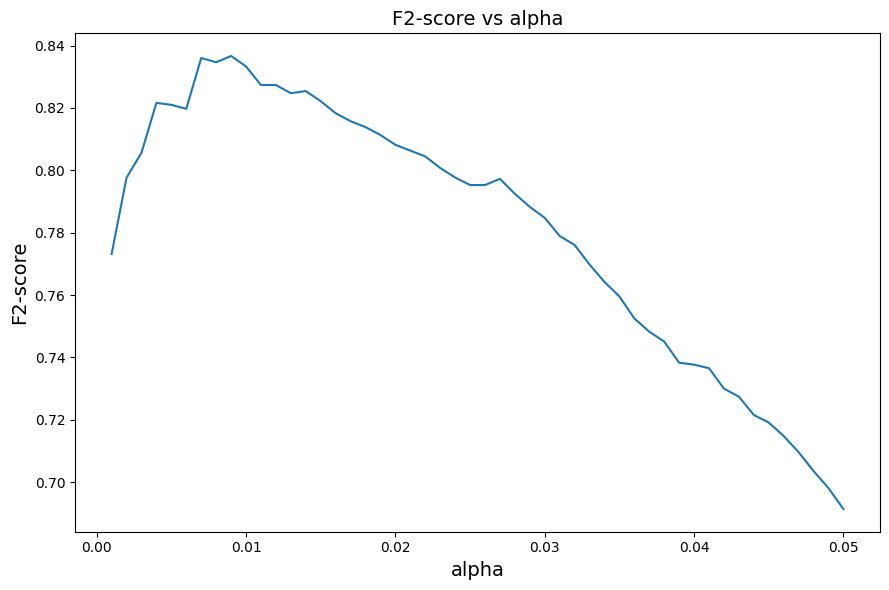

In [31]:
# plotting F-2 Score over alpha
plt.figure(figsize=(9,6))
plt.plot(alpha_list, f2_list)
plt.xlabel("alpha", fontsize=14)
plt.ylabel("F2-score", fontsize=14)
plt.title("F2-score vs alpha", fontsize=14)
plt.tight_layout()
plt.show()

In [33]:
# tuning summary
print(pd.Series({
    'Optimal alpha': alpha_opt,
    'Optimal F2-score': f2_score(y_val, y_val_pred_opt)
}).to_string())

Optimal alpha       0.009000
Optimal F2-score    0.836685


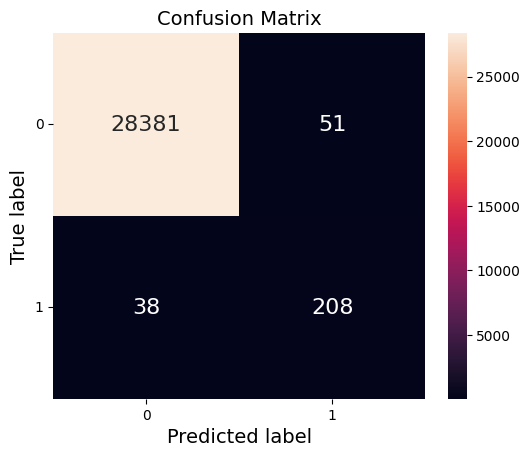

In [34]:
# Confusion matrix
conf_mat_heatmap(y_val, y_val_pred_opt)

## Prediction and Evalution on Test Set

In [47]:
# Function to compute and print evaluation metrics
def evaluation(y_test, y_pred):
    confusion_mat = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_mat[0, 0], confusion_mat[0, 1], confusion_mat[1, 0], confusion_mat[1, 1]
    print(pd.Series({
        "Accuracy": (tp + tn) / (tn + fp + fn + tp),
        "Precision": tp / (tp + fp),
        "Recall": tp / (tp + fn),
        "F1-score": (2 * tp) / ((2 * tp) + fn + fp),
        "F2-score": (5 * tp) / ((5 * tp) + (4 * fn) + fp),
        "MCC": ((tp * tn) - (fp * fn)) / np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    }).to_string())

In [48]:
# Prediction and evaluation on the test set
y_test_normal = model_normal(Fs_X_test, epsilon=alpha_opt**Fs_X_test.shape[1])
evaluation(y_test, y_test_normal)

Accuracy     0.996583
Precision    0.789062
Recall       0.821138
F1-score     0.804781
F2-score     0.814516
MCC          0.803220


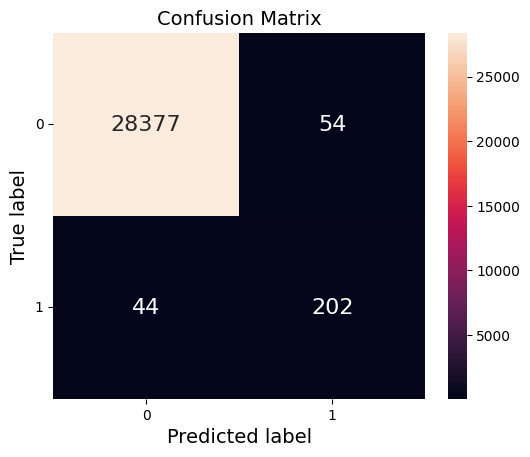

In [49]:
# Confusion matrix for prediction on the test set
conf_mat_heatmap(y_test, y_test_normal)

## Conclusion


To Conclude, we observed that the data is highly imbalanced with fraudulent transaction occurs rarely (approx 0.7%) compared to authentic transaction.Thus we build an anomaly detection system to detect the fraudulent transaction.

To decompose the 'Time' features into 'Day','Hour','Minute','Second' and observed that **'Hour'** considered to be good features compared to other as it give us more clearity that in day when most of the transaction occurs using credit card, so we exclude other features.

As given dataset dimensionality is very high, se select features which contributed in classifying transaction as authentic ans fraudulent, and discard other. This significantly reduced the dimensionality,here out of 30 features we select 9 which are **V4, V11, V12, V14, V16, V17, V18, V19 and Hour.**

Based on fit we fit multivariate normal distribution.. Given a new transaction, if the corresponding density value of the fitted distribution is lower than a pre-specified threshold, then we flag the transaction as fraudulent. The choice of the threshold is optimized by iterating over a pre-specified set of values, predicting on the validation set, and evaluating the estimates by means of the  
F2-score.

In this work,the optimal threshold value comes out to be (approx) **3.87 x 10^-19**. The corresponding F2-score for prediction on the  vlaidation set is **0.836685**.Applying the same model on the test set, we get predictions with an F2-score of **0.814516**
